In [37]:
# Read the 23andMe raw data file and turn it into a dataframe
import pandas as pd
import numpy as np
import sys

ttAndMe_dir = "../../Data/23andMe_metadata_files/23andMeGenePanel.csv"

# Read the text file into a DataFrame
ttAndMe = pd.read_csv(ttAndMe_dir, header=0)

ttAndMe['chromosome'] = ttAndMe['chromosome'].astype(str)

# Find all the positions in ttAndMe that are in PRS313 by identifying columns with the same position and chromosome
PRS313 = pd.read_excel('../../Data/PRS313.xlsx')

PRS313['in_23andMe'] = PRS313.apply(lambda x: ttAndMe[(ttAndMe['position'] == int(x['Positionb'])) & (ttAndMe['chromosome'] == str(x['Chromosome']))].shape[0] > 0, axis=1)

PRS313.to_excel('../../Data/PRS313_with_23andMe.xlsx', index=False)

PRS313

,SNPa,Chromosome,Positionb,Reference Allele,Effect Allele,EAFc,Overall Breast Cancerd,ER-positivee,ER-negativef,hybrid ER-positiveg,hybrid ER-negativeh,in_23andMe
0,1_100880328_A_T,1,100880328,A,T,0.409678,0.0373,0.0355,0.0160,0.0373,0.0373,False
1,1_10566215_A_G,1,10566215,A,G,0.329016,-0.0586,-0.0407,-0.1109,-0.0407,-0.1109,True
2,1_110198129_CAAA_C,1,110198129,CAAA,C,0.775478,0.0458,0.0545,0.0266,0.0458,0.0458,False
3,1_114445880_G_A,1,114445880,G,A,0.166363,0.0621,0.0642,0.0579,0.0621,0.0621,False
4,1_118141492_A_C,1,118141492,A,C,0.265682,0.0452,0.0417,0.0551,0.0452,0.0452,False
...,...,...,...,...,...,...,...,...,...,...,...,...
308,22_39343916_T_A,22,39343916,T,A,0.254083,0.0407,0.0326,0.0330,0.0407,0.0407,True
309,22_40904707_CT_C,22,40904707,CT,C,0.109871,0.1148,0.1160,0.1203,0.1148,0.1148,False
310,22_43433100_C_T,22,43433100,C,T,0.114445,-0.0600,-0.0585,-0.0515,-0.0600,-0.0600,False
311,22_45319953_G_A,22,45319953,G,A,0.416619,-0.0134,-0.0060,-0.0611,-0.0060,-0.0611,False


In [38]:
sum(PRS313["in_23andMe"])

77

In [ ]:
import os
import pandas as pd
import re
from datetime import datetime

# Set the path to the folder containing the 23andMe files
folder_path = "../../Data/23andMe_files"

# Read the PRS313 file
PRS313 = pd.read_excel('../../Data/PRS313.xlsx')

# Initialize a dictionary to store the results
result_dict = {}

# Initialize a set to store the unique positions from all 23andMe files
unique_positions_set = set()

# Initialize a dictionary to store the counts of positions from each 23andMe file
position_counts = {}

reference_23andMe_Genome = pd.read_excel("../../Data/PRS313_23andMe_PRS313_intersection.xlsx")

# Iterate over each file in the folder
for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)
    try:
        # Read the first line of the 23andMe raw data file
        with open(file_path, 'r') as file:
            first_line = file.readline()

        # Extract the date and company information from the first line
        date_match = re.search(r"# This data file generated by 23andMe at: (.*)", first_line)
        company_match = re.search(r"# This data file generated by (.*) at:", first_line)

        if date_match and company_match:
            date_str = date_match.group(1)
            company = company_match.group(1)

            # Parse the date string
            date = datetime.strptime(date_str, "%a %b %d %H:%M:%S %Y")

            # Check if the file is from 23andMe and generated after January 1st, 2022
            if company != "23andMe" or date < datetime(2022, 1, 1):
                print(f"File {filename} is not from 23andMe or generated before January 1st, 2022. Deleting the file.")
                os.remove(file_path)
                continue
        else:
            print(f"File {filename} does not contain the required date or company information. Deleting the file.")
            os.remove(file_path)
            continue

        # Read the 23andMe raw data into a DataFrame
        ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])

        # If the number of positions is greater than 700000 or less than 600000, delete the file and move on
        if ttAndMe.shape[0] > 700000 or ttAndMe.shape[0] < 600000:
            print(f"File {filename} has an invalid number of positions: {ttAndMe.shape[0]}. Deleting the file.")
            os.remove(file_path)
            continue



        # Merge the 23andMe DataFrame with the PRS313 DataFrame based on chromosome and position
        merged_df = pd.merge(ttAndMe, PRS313[['SNPa', 'Chromosome', 'Positionb']], left_on=['chromosome', 'position'], right_on=['Chromosome', 'Positionb'], how='inner')

        # Count the presence of each SNP in the merged DataFrame
        snp_presence = merged_df.groupby('SNPa').size().reindex(PRS313['SNPa'], fill_value=0).astype(bool)

        # Count the total number of SNPs present
        total_snps_present = snp_presence.sum()

        # Count the total number of positions in the 23andMe file
        total_positions = ttAndMe.shape[0]

        # Store the results in the dictionary
        result_dict[filename] = list(snp_presence) + [total_snps_present, total_positions]

        # Update the unique positions set
        unique_positions_set.update(zip(ttAndMe['chromosome'], ttAndMe['position']))

        # Update the position counts dictionary
        for pos in zip(ttAndMe['chromosome'], ttAndMe['position']):
            position_counts[pos] = position_counts.get(pos, 0) + 1

    except Exception as e:
        print(f"Error processing file {filename}: {e}")
        os.remove(file_path)
        continue

# Create the result DataFrame from the dictionary
result_df = pd.DataFrame.from_dict(result_dict, orient='index', columns=PRS313['SNPa'].tolist() + ['total_snps_present', 'total_positions'])

# Save the results to Excel files
result_df.to_excel('../../Data/PRS313_23andMe_PRS313_intersection.xlsx', index_label='filename')

/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/1266322652.py:51: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/1266322652.py:51: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/1266322652.py:51: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/1266322652.

File 11864.23andme.9744.txt is not from 23andMe or generated before January 1st, 2022. Deleting the file.


/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/1266322652.py:51: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])


File 12266.23andme.10102.txt is not from 23andMe or generated before January 1st, 2022. Deleting the file.


/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/1266322652.py:51: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/1266322652.py:51: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/1266322652.py:51: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])


File 12247.23andme.10091.txt is not from 23andMe or generated before January 1st, 2022. Deleting the file.


/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/1266322652.py:51: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/1266322652.py:51: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/1266322652.py:51: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/1266322652.

File 11960.23andme.9830.txt does not contain the required date or company information. Deleting the file.


/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/1266322652.py:51: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/1266322652.py:51: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/1266322652.py:51: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/1266322652.

File 11942.23andme.9813.txt is not from 23andMe or generated before January 1st, 2022. Deleting the file.


/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/1266322652.py:51: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/1266322652.py:51: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/1266322652.py:51: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/1266322652.

File 12166.23andme.10014.txt does not contain the required date or company information. Deleting the file.
File 12308.23andme.10140.txt is not from 23andMe or generated before January 1st, 2022. Deleting the file.


/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/1266322652.py:51: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/1266322652.py:51: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])


File 11717.23andme.9627.txt is not from 23andMe or generated before January 1st, 2022. Deleting the file.


/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/1266322652.py:51: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/1266322652.py:51: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])


File 11865.23andme.9745.txt is not from 23andMe or generated before January 1st, 2022. Deleting the file.


/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/1266322652.py:51: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/1266322652.py:51: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/1266322652.py:51: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])


File 12288.23andme.10121.txt is not from 23andMe or generated before January 1st, 2022. Deleting the file.


/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/1266322652.py:51: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/1266322652.py:51: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/1266322652.py:51: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])


File 11871.23andme.9750.txt does not contain the required date or company information. Deleting the file.
File 12450.23andme.10270.txt is not from 23andMe or generated before January 1st, 2022. Deleting the file.


/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/1266322652.py:51: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/1266322652.py:51: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/1266322652.py:51: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/1266322652.

File 12258.23andme.10097.txt is not from 23andMe or generated before January 1st, 2022. Deleting the file.


/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/1266322652.py:51: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/1266322652.py:51: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/1266322652.py:51: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])


File 11713.23andme.9624.txt is not from 23andMe or generated before January 1st, 2022. Deleting the file.


/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/1266322652.py:51: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])


File 12018.23andme.9881.txt is not from 23andMe or generated before January 1st, 2022. Deleting the file.


/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/1266322652.py:51: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])


File 11708.23andme.9621.txt is not from 23andMe or generated before January 1st, 2022. Deleting the file.


/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/1266322652.py:51: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/1266322652.py:51: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])


File 10817.23andme.9944.txt is not from 23andMe or generated before January 1st, 2022. Deleting the file.


/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/1266322652.py:51: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/1266322652.py:51: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/1266322652.py:51: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/1266322652.

File 9962.23andme.9686.txt does not contain the required date or company information. Deleting the file.


/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/1266322652.py:51: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/1266322652.py:51: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/1266322652.py:51: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/1266322652.

File 12307.23andme.10136.txt is not from 23andMe or generated before January 1st, 2022. Deleting the file.


/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/1266322652.py:51: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/1266322652.py:51: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/1266322652.py:51: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])


File 11999.23andme.9863.txt is not from 23andMe or generated before January 1st, 2022. Deleting the file.


/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/1266322652.py:51: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/1266322652.py:51: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/1266322652.py:51: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/1266322652.

File 11977.23andme.9843.txt is not from 23andMe or generated before January 1st, 2022. Deleting the file.


/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/1266322652.py:51: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/1266322652.py:51: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/1266322652.py:51: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/1266322652.

File 12448.23andme.10268.txt does not contain the required date or company information. Deleting the file.
File 12061.23andme.9919.txt does not contain the required date or company information. Deleting the file.
File genome_Dorothy_Wolf_v4_Full_20170525101345.txt is not from 23andMe or generated before January 1st, 2022. Deleting the file.
File 11698.23andme.9613.txt is not from 23andMe or generated before January 1st, 2022. Deleting the file.


/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/1266322652.py:51: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/1266322652.py:51: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])


File 12047.23andme.9903.txt is not from 23andMe or generated before January 1st, 2022. Deleting the file.


/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/1266322652.py:51: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/1266322652.py:51: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/1266322652.py:51: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/1266322652.

File 11852.23andme.9735.txt is not from 23andMe or generated before January 1st, 2022. Deleting the file.
File 11161.23andme.9695.txt is not from 23andMe or generated before January 1st, 2022. Deleting the file.
File 11837.23andme.9721.txt does not contain the required date or company information. Deleting the file.
File 12040.23andme.9897.txt is not from 23andMe or generated before January 1st, 2022. Deleting the file.


/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/1266322652.py:51: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/1266322652.py:51: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])


File 11858.23andme.9740.txt does not contain the required date or company information. Deleting the file.
File 12319.23andme.10151.txt is not from 23andMe or generated before January 1st, 2022. Deleting the file.
File 12250.23andme.10093.txt is not from 23andMe or generated before January 1st, 2022. Deleting the file.


/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/1266322652.py:51: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/1266322652.py:51: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])


File 11936.23andme.9808.txt is not from 23andMe or generated before January 1st, 2022. Deleting the file.


/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/1266322652.py:51: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/1266322652.py:51: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/1266322652.py:51: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])


File 12363.23andme.10193.txt is not from 23andMe or generated before January 1st, 2022. Deleting the file.


/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/1266322652.py:51: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/1266322652.py:51: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/1266322652.py:51: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])


File 12043.23andme.9901.txt does not contain the required date or company information. Deleting the file.
File 12082.23andme.9950.txt is not from 23andMe or generated before January 1st, 2022. Deleting the file.
File 11802.23andme.9696.txt is not from 23andMe or generated before January 1st, 2022. Deleting the file.
File 12181.23andme.10032.txt does not contain the required date or company information. Deleting the file.
File 11968.23andme.9834.txt is not from 23andMe or generated before January 1st, 2022. Deleting the file.


/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/1266322652.py:51: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/1266322652.py:51: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/1266322652.py:51: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/1266322652.

File 12064.23andme.9922.txt is not from 23andMe or generated before January 1st, 2022. Deleting the file.
File 11682.23andme.9601.txt is not from 23andMe or generated before January 1st, 2022. Deleting the file.


/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/1266322652.py:51: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])


File 11920.23andme.9795.txt is not from 23andMe or generated before January 1st, 2022. Deleting the file.


/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/1266322652.py:51: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/1266322652.py:51: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])


File 12368.23andme.10199.txt is not from 23andMe or generated before January 1st, 2022. Deleting the file.


/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/1266322652.py:51: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/1266322652.py:51: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/1266322652.py:51: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/1266322652.

File 12068.23andme.9928.txt is not from 23andMe or generated before January 1st, 2022. Deleting the file.


/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/1266322652.py:51: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/1266322652.py:51: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/1266322652.py:51: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])


File 11580.23andme.9468.txt is not from 23andMe or generated before January 1st, 2022. Deleting the file.


/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/1266322652.py:51: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])


File 12114.23andme.9977.txt is not from 23andMe or generated before January 1st, 2022. Deleting the file.


/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/1266322652.py:51: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])


File 11941.23andme.9812.txt is not from 23andMe or generated before January 1st, 2022. Deleting the file.


/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/1266322652.py:51: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])


File 12277.23andme.10113.txt does not contain the required date or company information. Deleting the file.


/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/1266322652.py:51: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/1266322652.py:51: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/1266322652.py:51: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/1266322652.

File 12375.23andme.10205.txt is not from 23andMe or generated before January 1st, 2022. Deleting the file.


/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/1266322652.py:51: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/1266322652.py:51: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/1266322652.py:51: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/1266322652.

In [10]:
import os
import pandas as pd
import re
from datetime import datetime

# Set the path to the folder containing the 23andMe files
folder_path = "../../Data/23andMe_files"

# Read the PRS313 file
PRS313 = pd.read_excel('../../Data/PRS313.xlsx')

# Read the reference 23andMe genome file
reference_file = "genome_Chad_Wrye_v5_Full_20220921063742.txt"
reference_file_path = os.path.join(folder_path, reference_file)

# Read the reference file into a DataFrame
reference_23andMe_Genome = pd.read_csv(reference_file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])

# Initialize a dictionary to store the results
result_dict = {}

# Initialize a set to store the unique positions from all 23andMe files
unique_positions_set = set()

# Initialize a dictionary to store the counts of positions from each 23andMe file
position_counts = {}

# Iterate over each file in the folder
for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)
    try:
        # Read the first line of the 23andMe raw data file
        with open(file_path, 'r') as file:
            first_line = file.readline()

        # Extract the date and company information from the first line
        date_match = re.search(r"# This data file generated by 23andMe at: (.*)", first_line)
        company_match = re.search(r"# This data file generated by (.*) at:", first_line)

        if date_match and company_match:
            date_str = date_match.group(1)
            company = company_match.group(1)

            # Parse the date string
            date = datetime.strptime(date_str, "%a %b %d %H:%M:%S %Y")

            # Check if the file is from 23andMe and generated after January 1st, 2022
            if company != "23andMe" or date < datetime(2022, 1, 1):
                print(f"File {filename} is not from 23andMe or generated before January 1st, 2022. Deleting the file.")
                os.remove(file_path)
                continue
        else:
            print(f"File {filename} does not contain the required date or company information. Deleting the file.")
            os.remove(file_path)
            continue

        # Read the 23andMe raw data into a DataFrame
        ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])

        # If the number of positions is greater than 700000 or less than 600000, delete the file and move on
        if ttAndMe.shape[0] > 700000 or ttAndMe.shape[0] < 600000:
            print(f"File {filename} has an invalid number of positions: {ttAndMe.shape[0]}. Deleting the file.")
            os.remove(file_path)
            continue

        # Merge the 23andMe DataFrame with the PRS313 DataFrame based on chromosome and position
        merged_df = pd.merge(ttAndMe, PRS313[['SNPa', 'Chromosome', 'Positionb']], left_on=['chromosome', 'position'], right_on=['Chromosome', 'Positionb'], how='inner')

        # Count the presence of each SNP in the merged DataFrame
        snp_presence = merged_df.groupby('SNPa').size().reindex(PRS313['SNPa'], fill_value=0).astype(bool)

        # Count the total number of SNPs present
        total_snps_present = snp_presence.sum()

        # Check if at least 60% of the SNPs are in common with the reference 23andMe genome
        reference_snps = set(reference_23andMe_Genome['rsid'])
        file_snps = set(ttAndMe['rsid'])
        common_snps = reference_snps.intersection(file_snps)
        percentage_common_snps = len(common_snps) / len(reference_snps) * 100

        if percentage_common_snps < 60:
            print(f"File {filename} has less than 60% of SNPs in common with the reference 23andMe genome. Deleting the file.")
            os.remove(file_path)
            continue

        # Count the total number of positions in the 23andMe file
        total_positions = ttAndMe.shape[0]

        # Store the results in the dictionary
        result_dict[filename] = list(snp_presence) + [total_snps_present, total_positions]

        # Update the unique positions set
        unique_positions_set.update(zip(ttAndMe['chromosome'], ttAndMe['position']))

        # Update the position counts dictionary
        for pos in zip(ttAndMe['chromosome'], ttAndMe['position']):
            position_counts[pos] = position_counts.get(pos, 0) + 1

    except Exception as e:
        print(f"Error processing file {filename}: {e}")
        os.remove(file_path)
        continue

# Create the result DataFrame from the dictionary
result_df = pd.DataFrame.from_dict(result_dict, orient='index', columns=PRS313['SNPa'].tolist() + ['total_snps_present', 'total_positions'])

# Save the results to Excel files
result_df.to_excel('../../Data/23andMe_metadata_files/PRS313_23andMe_PRS313_intersection.xlsx', index_label='filename')

/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/3561432251.py:17: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  reference_23andMe_Genome = pd.read_csv(reference_file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/3561432251.py:58: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/3561432251.py:58: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/

File 12421.23andme.10246.txt has less than 60% of SNPs in common with the reference 23andMe genome. Deleting the file.


/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/3561432251.py:58: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/3561432251.py:58: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/3561432251.py:58: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/3561432251.

File 11847.23andme.9728.txt has less than 60% of SNPs in common with the reference 23andMe genome. Deleting the file.


/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/3561432251.py:58: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/3561432251.py:58: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/3561432251.py:58: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])


File 11643.23andme.9571.txt has less than 60% of SNPs in common with the reference 23andMe genome. Deleting the file.


/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/3561432251.py:58: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/3561432251.py:58: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/3561432251.py:58: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/3561432251.

File 12417.23andme.10240.txt has less than 60% of SNPs in common with the reference 23andMe genome. Deleting the file.


/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/3561432251.py:58: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/3561432251.py:58: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])


File 12010.23andme.9873.txt has less than 60% of SNPs in common with the reference 23andMe genome. Deleting the file.


/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/3561432251.py:58: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/3561432251.py:58: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/3561432251.py:58: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])


File 5892.23andme.9731.txt has less than 60% of SNPs in common with the reference 23andMe genome. Deleting the file.


/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/3561432251.py:58: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/3561432251.py:58: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/3561432251.py:58: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/3561432251.

File 11687.23andme.9605.txt has less than 60% of SNPs in common with the reference 23andMe genome. Deleting the file.


/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/3561432251.py:58: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/3561432251.py:58: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/3561432251.py:58: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/3561432251.

File 11662.23andme.9585.txt has less than 60% of SNPs in common with the reference 23andMe genome. Deleting the file.


/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/3561432251.py:58: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])


File 12325.23andme.10160.txt has less than 60% of SNPs in common with the reference 23andMe genome. Deleting the file.


/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/3561432251.py:58: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/3561432251.py:58: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/3561432251.py:58: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/3561432251.

File 4015.23andme.10141.txt has less than 60% of SNPs in common with the reference 23andMe genome. Deleting the file.


/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/3561432251.py:58: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/3561432251.py:58: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/3561432251.py:58: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/3561432251.

File 5892.23andme.9983.txt has less than 60% of SNPs in common with the reference 23andMe genome. Deleting the file.


/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/3561432251.py:58: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/3561432251.py:58: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/3561432251.py:58: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_50529/3561432251.

In [11]:
output_folder = "../../Data/23andMe_metadata_files/"

os.makedirs(output_folder, exist_ok=True)

# Create a DataFrame with unique positions
unique_positions_df = pd.DataFrame(list(unique_positions_set), columns=['chromosome', 'position'])
unique_positions_df = unique_positions_df.astype(str)

unique_positions_df.to_parquet(f'{output_folder}23andMe_unique_positions.parquet', index=False)

# Find the positions present in all 23andMe files
num_files = len(result_dict)
intersection_positions_100 = [pos for pos, count in position_counts.items() if count == num_files]
intersection_positions_95 = [pos for pos, count in position_counts.items() if count > 0.95 * num_files]
intersection_positions_90 = [pos for pos, count in position_counts.items() if count > 0.9 * num_files]
intersection_positions_85 = [pos for pos, count in position_counts.items() if count > 0.85 * num_files]
intersection_positions_80 = [pos for pos, count in position_counts.items() if count > 0.8 * num_files]
intersection_positions_75 = [pos for pos, count in position_counts.items() if count > 0.75 * num_files]
intersection_positions_70 = [pos for pos, count in position_counts.items() if count > 0.7 * num_files]
intersection_positions_65 = [pos for pos, count in position_counts.items() if count > 0.65 * num_files]
intersection_positions_60 = [pos for pos, count in position_counts.items() if count > 0.65 * num_files]


intersection_positions_df_100 = pd.DataFrame(intersection_positions_100, columns=['chromosome', 'position']).astype(str)
intersection_positions_df_95 = pd.DataFrame(intersection_positions_95, columns=['chromosome', 'position']).astype(str)
intersection_positions_df_90 = pd.DataFrame(intersection_positions_90, columns=['chromosome', 'position']).astype(str)
intersection_positions_df_85 = pd.DataFrame(intersection_positions_85, columns=['chromosome', 'position']).astype(str)
intersection_positions_df_80 = pd.DataFrame(intersection_positions_80, columns=['chromosome', 'position']).astype(str)
intersection_positions_df_75 = pd.DataFrame(intersection_positions_75, columns=['chromosome', 'position']).astype(str)
intersection_positions_df_70 = pd.DataFrame(intersection_positions_70, columns=['chromosome', 'position']).astype(str)
intersection_positions_df_65 = pd.DataFrame(intersection_positions_65, columns=['chromosome', 'position']).astype(str)
intersection_positions_df_60 = pd.DataFrame(intersection_positions_60, columns=['chromosome', 'position']).astype(str)

# Save the intersection positions to Excel files

intersection_positions_df_100.to_parquet(f'{output_folder}23andMe_intersection_positions_100.parquet', index=False)
intersection_positions_df_95.to_parquet(f'{output_folder}23andMe_intersection_positions_95.parquet', index=False)
intersection_positions_df_90.to_parquet(f'{output_folder}23andMe_intersection_positions_90.parquet', index=False)
intersection_positions_df_85.to_parquet(f'{output_folder}23andMe_intersection_positions_85.parquet', index=False)
intersection_positions_df_80.to_parquet(f'{output_folder}23andMe_intersection_positions_80.parquet', index=False)
intersection_positions_df_75.to_parquet(f'{output_folder}23andMe_intersection_positions_75.parquet', index=False)
intersection_positions_df_70.to_parquet(f'{output_folder}23andMe_intersection_positions_70.parquet', index=False)
intersection_positions_df_65.to_parquet(f'{output_folder}23andMe_intersection_positions_65.parquet', index=False)
intersection_positions_df_60.to_parquet(f'{output_folder}23andMe_intersection_positions_60.parquet', index=False)


In [23]:
intersection_positions_df_80.to_csv(f'{output_folder}23andMe_intersection_positions_80.tsv', index=False, sep='\t')
# Convert the unique positions set to a DataFrame
unique_positions_df = pd.DataFrame(list(unique_positions_set), columns=['chromosome', 'position'])

# Save the unique positions DataFrame as a CSV file
unique_positions_df.to_csv('../../Data/23andMe_metadata_files/23andMeGenePanel.csv', index=False)

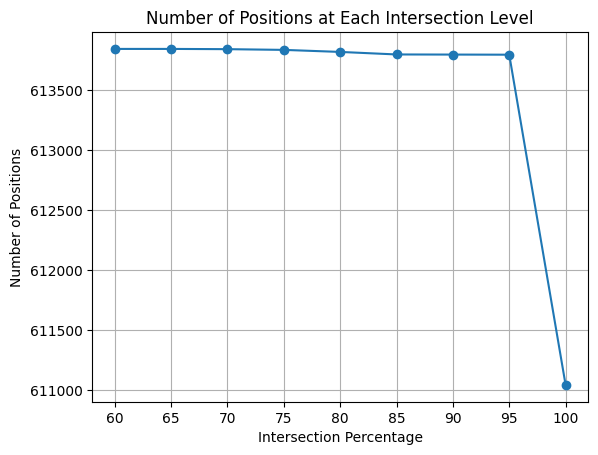

In [13]:
# Graph the number of positions at each intersection level. Plot every 5% from 60% to 100%
import matplotlib.pyplot as plt

intersection_percentages = [60, 65, 70, 75, 80, 85, 90, 95, 100]
intersection_counts = [intersection_positions_df_60.shape[0], intersection_positions_df_65.shape[0], intersection_positions_df_70.shape[0], intersection_positions_df_75.shape[0],
                       intersection_positions_df_80.shape[0], intersection_positions_df_85.shape[0], intersection_positions_df_90.shape[0], intersection_positions_df_95.shape[0], intersection_positions_df_100.shape[0]]

plt.plot(intersection_percentages, intersection_counts, marker='o')
plt.xlabel('Intersection Percentage')
plt.ylabel('Number of Positions')
plt.title('Number of Positions at Each Intersection Level')
plt.grid()
plt.show()

In [14]:
print("Number of unique positions in all 23andMe files:", len(unique_positions_set))

Number of unique positions in all 23andMe files: 663522


In [21]:
# Save unique_positions_set as a CSV file



{(13, 113046933),
 ('19', 8414177),
 (3, 28198031),
 (1, 240209273),
 (9, 36824086),
 ('20', 42754029),
 (15, 81272072),
 (4, 3076624),
 (3, 113320477),
 (6, 95114249),
 ('X', 86407623),
 (2, 80805202),
 ('18', 11718678),
 ('18', 49124975),
 (5, 10965979),
 ('Y', 22953894),
 (2, 171920785),
 (1, 26633190),
 ('18', 74773968),
 ('X', 78912323),
 (1, 200140425),
 (1, 68243397),
 (12, 47677812),
 ('20', 41255249),
 ('17', 66483670),
 (11, 7212657),
 (4, 36285777),
 ('Y', 21480778),
 (16, 69733009),
 (3, 112843639),
 (6, 135025753),
 (13, 71846744),
 (13, 28989008),
 (15, 25841802),
 (13, 34131102),
 (6, 24886536),
 (1, 81342137),
 (5, 2910083),
 (16, 1262093),
 (8, 53467470),
 (2, 148471037),
 ('18', 77282558),
 ('18', 76998877),
 (14, 83507309),
 (4, 142344038),
 (14, 31645344),
 (1, 143517337),
 ('X', 67874382),
 (6, 31253878),
 (6, 111288941),
 (6, 138101705),
 (14, 22615451),
 (1, 30396075),
 ('18', 67659639),
 (4, 186997767),
 ('22', 45415430),
 ('Y', 18028661),
 (11, 88257530),
 ('18

In [20]:
len(intersection_positions_df_60)

613840

# Convert all the 23andMe files to text files

In [36]:
# Set the path to the folder containing the 23andMe files
folder_path = "../../Data/23andMe_files"

# Convert all the 23andMe files to .txt format if they are not already in that format

for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)
    
    # Check if the file is already in .txt format
    if not filename.endswith('.txt'):
        new_file_path = os.path.join(folder_path, filename + '.txt')
        os.rename(file_path, new_file_path)
        print(f"Renamed {filename} to {filename.split('.')[0] + '.txt'}")
        

Renamed 12102.23andme.9966 to 12102.txt
Renamed 11864.23andme.9744 to 11864.txt
Renamed 11826.23andme.9708 to 11826.txt
Renamed 11703.23andme.9619 to 11703.txt
Renamed 12065.23andme.9923 to 12065.txt
Renamed 11936.23andme.9808 to 11936.txt
Renamed 12299.23andme.10131 to 12299.txt
Renamed 11874.23andme.9752 to 11874.txt
Renamed 12072.23andme.9932 to 12072.txt
Renamed 11662.23andme.9585 to 11662.txt
Renamed 12192.23andme.10043 to 12192.txt
Renamed 11983.23andme.9848 to 11983.txt
Renamed 11775.23andme.9673 to 11775.txt
Renamed 11919.23andme.9794 to 11919.txt
Renamed 11850.23andme.9730 to 11850.txt
Renamed 11765.23andme.9663 to 11765.txt
Renamed 12266.23andme.10102 to 12266.txt
Renamed 12155.23andme.10004 to 12155.txt
Renamed 10936.23andme.9481 to 10936.txt
Renamed 11993.23andme.9860 to 11993.txt
Renamed 12018.23andme.9881 to 12018.txt
Renamed 11919.23andme.9793 to 11919.txt
Renamed 11957.23andme.9826 to 11957.txt
Renamed 11722.23andme.9630 to 11722.txt
Renamed 11654.23andme.9576 to 11654.

In [15]:
# Print number of files in the folder
len(os.listdir(folder_path))


119